Questo codice ho iniziato a scriverlo il 5 Marzo con l'idea di analizzare gli embeddings di InfoGraph e fare clustering dividendo per source vista la correlazione degli embeddings per la lunghezza. Questo codice prende molte celle e idee da Embedding_UMLS_and_InfoGraph.

In [1]:
import json
import pandas as pd
import os
from tqdm.notebook import tqdm
import xml.etree.ElementTree as ET
import requests
import numpy as np

import pickle

Importo i file pickle relativi agli embedding di InfoGraph

Osservo che non rimuovo i documenti senza annotations perchè probabilmente UMLS e le annotazioni in generale non saranno utili. QUindi layer 1 ha 86 documenti.

In [2]:
with open('FilePickles\EmbeddingLayer1and3_InfoGraphTRANSDUCTIVEhidden_dim32num_gc_layers3lr0.01_senza_AIFA.pkl', 'rb') as file: #importo gli embedding dei grafi di layer 3
    emb1and3 = pickle.load(file)
emb1 = emb1and3[0:86] # seleziono i primi 86 documenti, ovvero quelli relativi a layer 1
#siccome questi due file non contengono clinical entities!
emb3 = emb1and3[86:]

stringa_AIFA = '_senza_AIFA'

C:\Users\enduser\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\enduser\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 'Visualizzazione della similarità dei documenti tramite tsne')

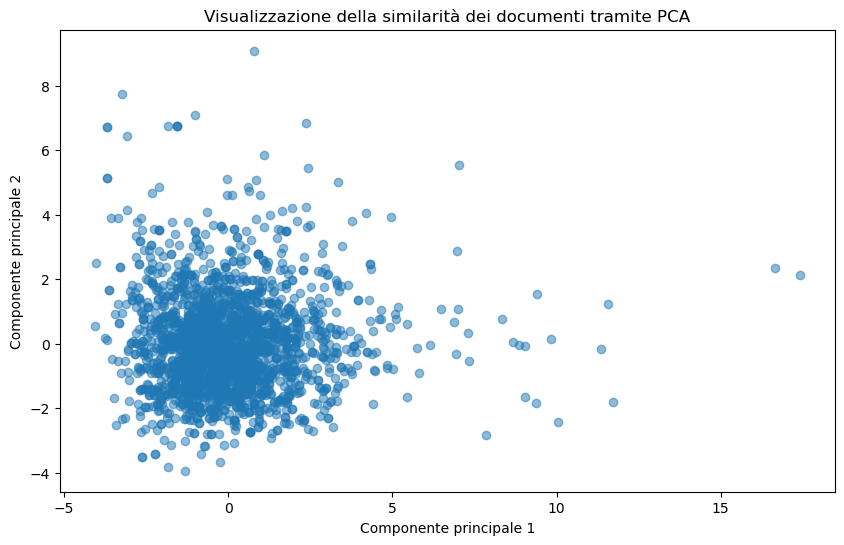

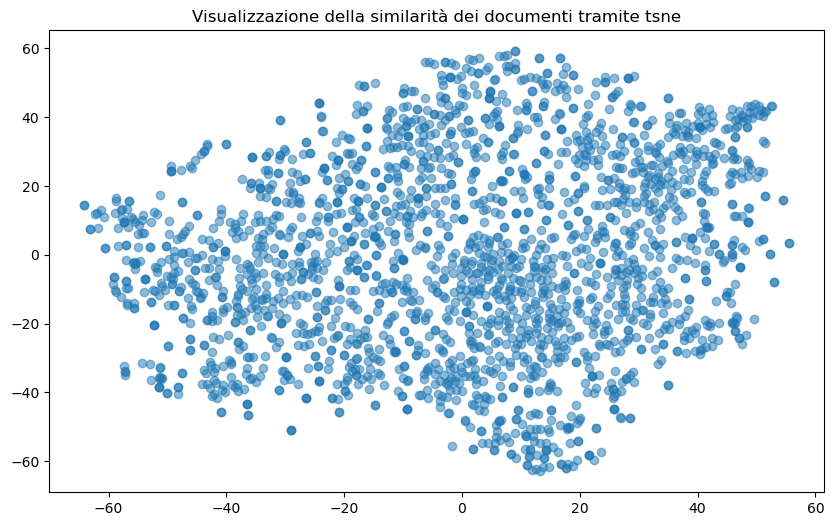

In [3]:
#PCA

document_vectors = emb1and3
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 2. Applica PCA per ridurre le dimensioni
pca = PCA(n_components=2)  # Vogliamo ridurre a due dimensioni per la visualizzazione
document_embedding = pca.fit_transform(document_vectors)

# 3. Visualizza i risultati
plt.figure(figsize=(10, 6))
plt.scatter(document_embedding[:, 0], document_embedding[:, 1], alpha=0.5)
plt.title('Visualizzazione della similarità dei documenti tramite PCA')
plt.xlabel('Componente principale 1')
plt.ylabel('Componente principale 2')


# TSNE

from sklearn import datasets
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
embeddings_tsneInfoGraph = tsne.fit_transform(emb1and3)  # embeddings è la tua matrice di embedding

# 3. Visualizza i risultati
plt.figure(figsize=(10, 6))
plt.scatter(embeddings_tsneInfoGraph[:, 0], embeddings_tsneInfoGraph[:, 1], alpha=0.5)
plt.title('Visualizzazione della similarità dei documenti tramite tsne')



# Layer1 analisi.

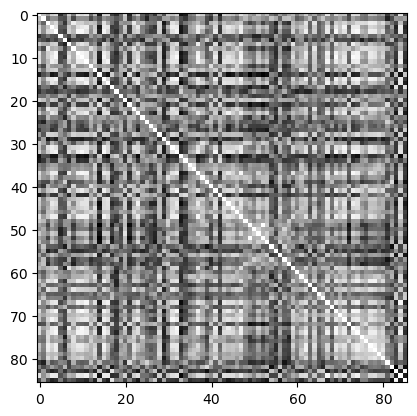

In [4]:
from sklearn.metrics.pairwise import cosine_similarity

# Calcola la matrice di similarità coseno
similarity_matrix = cosine_similarity(emb1) # calcolo matrice di similarità documenti
import matplotlib.pyplot as plt

plt.imshow(similarity_matrix, cmap='gray')
plt.show()

Numero di cluster: 2
Etichette dei cluster: [0 1 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0 0 1 1 0 0
 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0
 0 1 1 0 0 0 0 1 0 1 0 1]


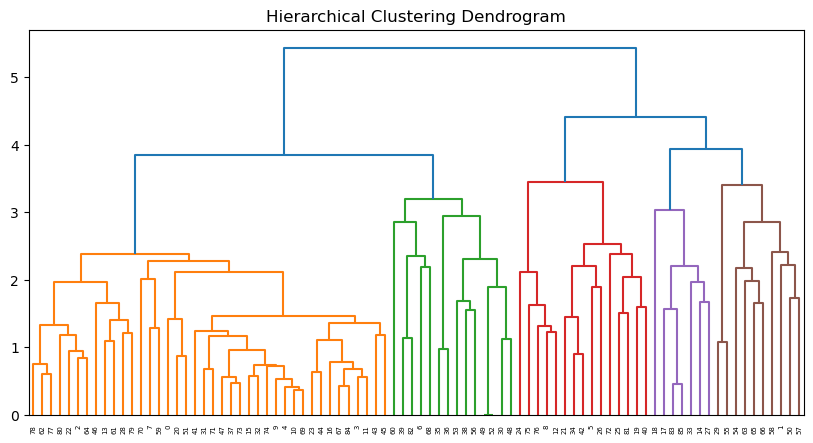

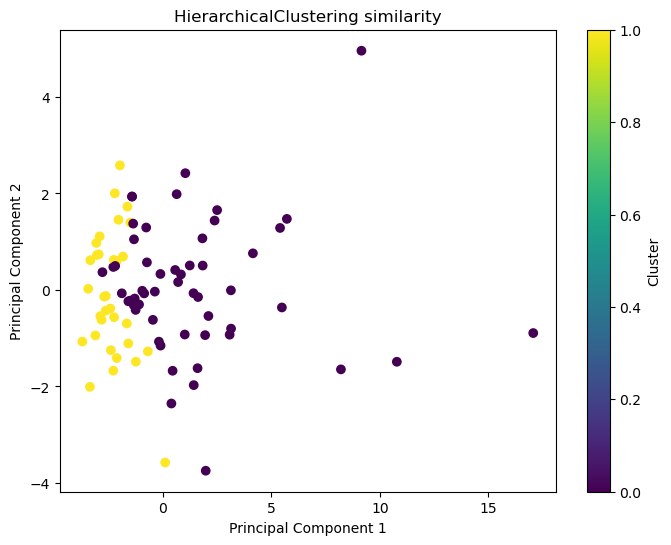

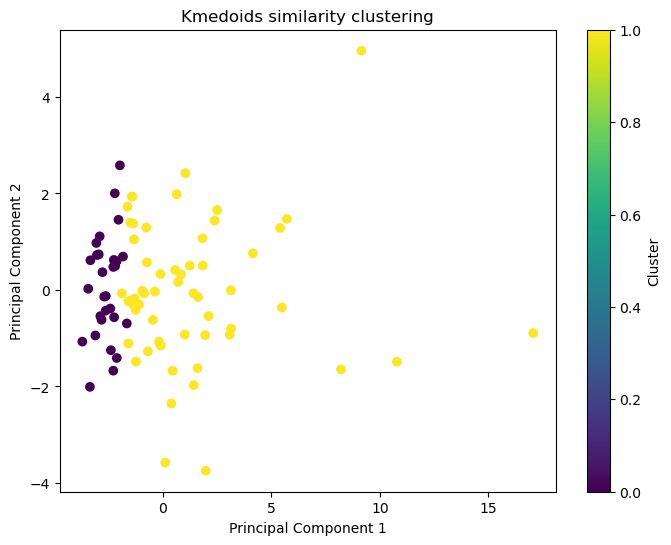

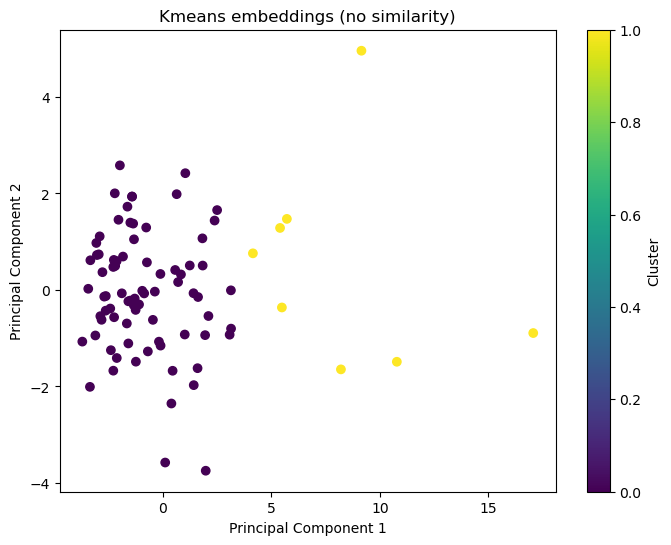

In [5]:
from sklearn.cluster import KMeans
# Hierarchical clustering
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
Z = linkage(similarity_matrix, method='average') # complete linkage mi sembra il migliore
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
from scipy.cluster.hierarchy import fcluster

max_d = 5  # Altezza di taglio del dendrogramma
clustersHierarchicalInfoGraph = fcluster(Z, max_d, criterion='distance')-1

num_clusters = len(set(clustersHierarchicalInfoGraph))
print(f"Numero di cluster: {num_clusters}")
print("Etichette dei cluster:", clustersHierarchicalInfoGraph)

#KMEDOIDS

from sklearn_extra.cluster import KMedoids

kmedoids = KMedoids(n_clusters=2, random_state=0)
kmedoids.fit(similarity_matrix)
clustersKMEDOIDSInfoGraph = kmedoids.labels_
centroids = similarity_matrix[kmedoids.medoid_indices_]

# infograph embedding:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(emb1)
clustersKMEANSInfoGraphEMB1 = kmeans.labels_


import numpy as np
from sklearn.decomposition import PCA

# Calcola PCA sui tuoi embedding
pca = PCA(n_components=2)  # Specifica il numero di componenti principali desiderate
embeddings_pca = pca.fit_transform(emb1)  # embeddings è la tua matrice di embedding

embeddings_pca = embeddings_pca[:86]

# Plotta i risultati
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=clustersHierarchicalInfoGraph[:86], cmap='viridis')
plt.title('HierarchicalClustering similarity')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=clustersKMEDOIDSInfoGraph[:86], cmap='viridis')
plt.title('Kmedoids similarity clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()


# Confrontiamo i due cluster precedenti con i cluster ottenuti direttamente dagli embedding (no matrice di similarità ma emb1and3)

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=clustersKMEANSInfoGraphEMB1[:86], cmap='viridis')
plt.title('Kmeans embeddings (no similarity)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()


In [6]:
explained_variance_ratio = pca.explained_variance_ratio_

print("Percentuale di varianza spiegata da ciascuna componente principale:")
for i, ratio in enumerate(explained_variance_ratio):
    print(f"PC{i+1}: {ratio*100:.2f}%")

Percentuale di varianza spiegata da ciascuna componente principale:
PC1: 64.82%
PC2: 10.23%


In [7]:

cartella = r"C:\Users\enduser\OneDrive - Politecnico di Milano\Ingegneria matematica\Tesi\ProveDiCodice\E3C-Corpus\data_collection\Italian\layer1"

lista_testi1 = []
lista_source1 = []

for filename in os.listdir(cartella):
    if filename.endswith(".json"):  # Assicurati che siano file JSON
        filepath = os.path.join(cartella, filename)
        with open(filepath, 'r', encoding='utf-8') as file:  # Specifica l'encoding come utf-8
            try:
                # Carica il contenuto del file JSON
                data = json.load(file)
                # Estrai il testo dal campo "text" se presente
                if "text" in data:
                    testo = data["text"]
                    lista_testi1.append(testo)
                if "source" in data:
                    source = data["source"]
                    lista_source1.append(source)
            except Exception as e:
                pass

In [8]:
import statistics

# Calcolo della media, deviazione standard e varianza
media = {}
deviazione_standard = {}
varianza = {}
somma = {}

for i,parola in enumerate(lista_source1):
    somma[parola] = somma.get(parola,0)+len((lista_testi1[i]))

for parola in somma:
    lunghezze_parole = [len(lista_testi1[i]) for i, word in enumerate(lista_source1) if word == parola]
    # questo è il core di tutto il codice (fa una lista delle lunghezze di tutti i documenti con la stessa source!)
    #print(lunghezze_parole)
    if len(lunghezze_parole) < 2:
        # Se c'è solo un dato, trattalo come deviazione standard zero e varianza zero
        deviazione_standard[parola] = 0
        varianza[parola] = 0
    else:
        deviazione_standard[parola] = statistics.stdev(lunghezze_parole)
        varianza[parola] = statistics.variance(lunghezze_parole)
    media[parola] = statistics.mean(lunghezze_parole)
    #print(deviazione_standard)
    #print(media)

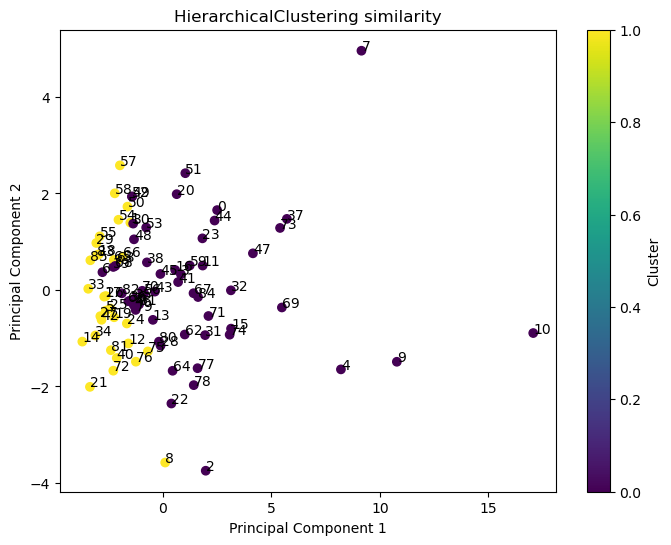

In [9]:
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=clustersHierarchicalInfoGraph[:86], cmap='viridis')
plt.title('HierarchicalClustering similarity')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')

for i, txt in enumerate(range(len(emb1))):
    plt.annotate(txt, (embeddings_pca[i, 0], embeddings_pca[i, 1]))

plt.show()

Dividiamo le sources fra Miur, Sapienza e il resto, vediamo la rappresentazione come viene

In [10]:
lista_source_short_layer1 = ['Miur','Sapienza Università di Roma']

lista_source_long_layer1 = [parola for parola in somma if parola not in lista_source_short_layer1]

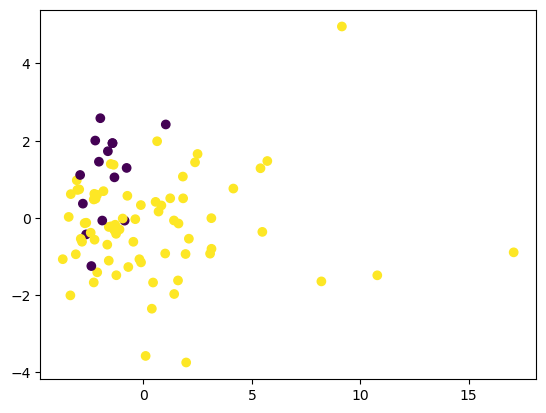

In [11]:
colorvecSource = []
for source in lista_source1:
    if source in lista_source_short_layer1:
        colorvecSource.append(0)
    if source in lista_source_long_layer1:
        colorvecSource.append(1)
        
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=colorvecSource)


stesso grafico di prima ma visualizzando gli embeddings con tsne

C:\Users\enduser\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\enduser\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


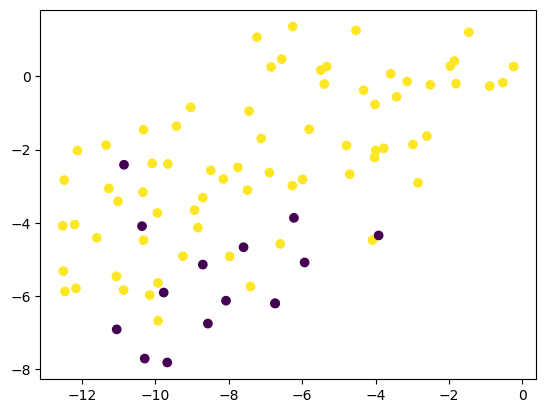

In [12]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(emb1)  # embeddings è la tua matrice di embedding
        
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=colorvecSource)

# Layer 3

In [13]:
cartella = r"C:\Users\enduser\OneDrive - Politecnico di Milano\Ingegneria matematica\Tesi\ProveDiCodice\E3C-Corpus\data_collection\Italian\layer3"

lista_testi3 = []
lista_source3 = []

for filename in os.listdir(cartella):
    if filename.endswith(".json"):  # Assicurati che siano file JSON
        filepath = os.path.join(cartella, filename)
        with open(filepath, 'r', encoding='utf-8') as file:  # Specifica l'encoding come utf-8
            try:
                # Carica il contenuto del file JSON
                data = json.load(file)
                # Estrai il testo dal campo "text" se presente
                if "text" in data and "source" in data:
                    testo = data["text"]
                    source = data["source"]
                    if source !='Agenzia Italiana del Farmaco':
                        lista_source3.append(source)
                        lista_testi3.append(testo)
                    
            except Exception as e:
                pass

In [14]:
import statistics

# Calcolo della media, deviazione standard e varianza
media = {}
deviazione_standard = {}
varianza = {}
somma = {}
maxx = {}
minn = {}

for i,parola in enumerate(lista_source3):
    somma[parola] = somma.get(parola,0)+len((lista_testi3[i]))

for parola in somma:
    lunghezze_parole = [len(lista_testi3[i]) for i, word in enumerate(lista_source3) if word == parola]
    # questo è il core di tutto il codice (fa una lista delle lunghezze di tutti i documenti con la stessa source!)
    #print(lunghezze_parole)
    if len(lunghezze_parole) < 2:
        # Se c'è solo un dato, trattalo come deviazione standard zero e varianza zero
        deviazione_standard[parola] = 0
        varianza[parola] = 0
    else:
        deviazione_standard[parola] = statistics.stdev(lunghezze_parole)
        varianza[parola] = statistics.variance(lunghezze_parole)
    media[parola] = statistics.mean(lunghezze_parole)
    minn[parola] = min(lunghezze_parole)
    maxx[parola] = max(lunghezze_parole)
    #print(deviazione_standard)
    #print(media)
    #print(minn)
    #print(maxx)

In [15]:
len(lista_source3)

2129

In [16]:
len(lista_testi3)

2129

In [17]:
lista_source_short_layer3 = ['Miur','Sapienza Università di Roma']

lista_source_long_layer3 = [parola for parola in somma if parola not in lista_source_short_layer1]

C:\Users\enduser\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\enduser\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


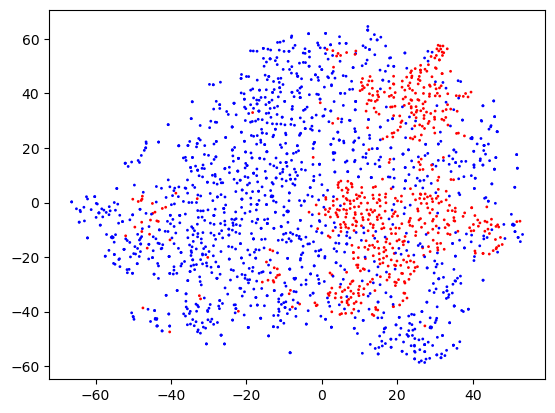

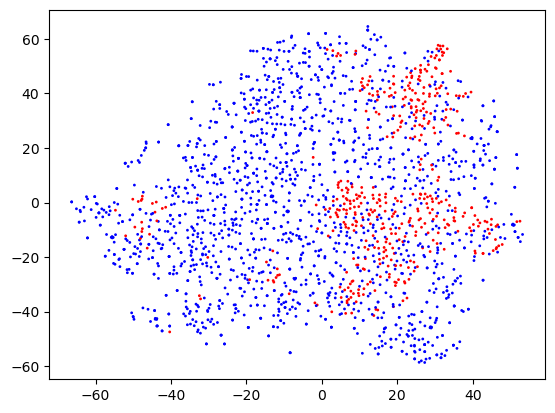

In [18]:
colorvecSource = []
for source in lista_source3:
    if source in lista_source_short_layer3:
        colorvecSource.append(0) #BLUE
    if source in lista_source_long_layer3:
        colorvecSource.append(1) #RED
        
colorvecLunghezza = []

for testo in lista_testi3:
    if len(testo) <1000: 
        colorvecLunghezza.append(0)#BLUE
    if len(testo)>1000:
        colorvecLunghezza.append(1) #RED

        
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(emb3)  # embeddings è la tua matrice di embedding
        
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=colorvecSource, cmap='bwr', s=1)
plt.show()

plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=colorvecLunghezza, cmap='bwr', s=1)
plt.show()

Creo dataframe pandas per lavorare meglio con i dati, ogni riga è un documento!

In [19]:
import pandas as pd

df = pd.DataFrame(columns = ['Index','Text','Length', 'Source'])
df['Index'] = list(range(len(lista_source3)))
df['Text'] = lista_testi3
df['Length'] = [len(text) for text in df['Text']]
df['Source'] = lista_source3
df['ColorvecLunghezza'] = colorvecLunghezza
df['ColorvecSource'] = colorvecSource
df['EmbeddingsTsneDim0'] = embeddings_tsne[:,0]
df['EmbeddingsTsneDim1'] = embeddings_tsne[:,1]

In [20]:
df['VecLunghezza'] = df['ColorvecLunghezza']

In [21]:
for i, val in enumerate(df['VecLunghezza']):
    if val == 0:
        df.loc[i, 'VecLunghezza'] = 'Corto'
    elif val == 1:
        df.loc[i, 'VecLunghezza'] = 'Lungo'

In [22]:
df

,Index,Text,Length,Source,ColorvecLunghezza,ColorvecSource,EmbeddingsTsneDim0,EmbeddingsTsneDim1,VecLunghezza
0,0,C.C. iniziava a fare dialisi all’età di 17 ann...,4372,GCND Giornale di Clinica Nefrologica e Dialisi,1,1,30.822714,57.652451,Lungo
1,1,I.Z. è un giovane di 22 anni. Pochi giorni pri...,6579,GCND Giornale di Clinica Nefrologica e Dialisi,1,1,32.106537,57.378700,Lungo
2,2,Nel giugno 2007 presso la Struttura Complessa ...,4478,GCND Giornale di Clinica Nefrologica e Dialisi,1,1,31.380047,57.387531,Lungo
3,3,Donna di 75 anni affetta da diabete mellito di...,2745,GCND Giornale di Clinica Nefrologica e Dialisi,1,1,37.489555,38.905788,Lungo
4,4,Nel settembre del 2008 giunge alla nostra osse...,5750,GCND Giornale di Clinica Nefrologica e Dialisi,1,1,33.237316,56.345196,Lungo
...,...,...,...,...,...,...,...,...,...
2124,2124,Femmina - aa. 77 –\n\nAnamnesi patologica remo...,13387,Prof. Dr. Francescopaolo Mattioli,1,1,32.300713,54.908382,Lungo
2125,2125,1° caso clinico\n\nFemmina - aa. 77\nAnamnesi ...,5799,Prof. Dr. Francescopaolo Mattioli,1,1,37.850964,-3.793020,Lungo
2126,2126,Maschio- aa. 52\n\nAnamnesi patologica remota\...,4758,Prof. Dr. Francescopaolo Mattioli,1,1,7.440516,0.583831,Lungo
2127,2127,"femmina, aa. 86\n\nAnamnesi patologica.\nprece...",4888,Prof. Dr. Francescopaolo Mattioli,1,1,4.437738,7.323576,Lungo


In [23]:
acc = [df['ColorvecLunghezza'] == df['ColorvecSource']]

sum(list(sum(list(acc))))

# c'è una corrispondenza quasi totale!

1957

In [24]:
dfMiurSap = df[df['ColorvecSource']==0]
dfOther = df[df['ColorvecSource']==1]

In [25]:
dfMiurSap

,Index,Text,Length,Source,ColorvecLunghezza,ColorvecSource,EmbeddingsTsneDim0,EmbeddingsTsneDim1,VecLunghezza
10,10,Un paziente di 72 anni con parkinsonismo prese...,112,Miur,0,0,-29.569483,-7.553520,Corto
11,11,Un paziente lamenta disuria e pollacchiuria. L...,122,Miur,0,0,-0.274836,-41.663464,Corto
12,12,Un paziente di 58 anni con una storia di 5 ann...,151,Miur,0,0,45.557388,37.235474,Corto
13,13,Un garagista di 26 anni ï¿½ a letto da 3 giorn...,263,Miur,0,0,-8.708750,0.667452,Corto
14,14,"Una paziente di 28 anni, all'ottavo mese di gr...",107,Miur,0,0,-2.638009,27.995195,Corto
...,...,...,...,...,...,...,...,...,...
2115,2115,Una donna di 43 anni con una diagnosi di Lupus...,356,Miur,0,0,-22.994982,-40.440933,Corto
2116,2116,Un uomo di 73 anni si presenta all'attenzione ...,276,Miur,0,0,36.504200,-13.809549,Corto
2117,2117,"Si reca in ambulatorio un paziente di 45 anni,...",238,Miur,0,0,-5.753240,38.459591,Corto
2118,2118,"Si reca in ambulatorio un paziente di 45 anni,...",238,Miur,0,0,-5.753242,38.461311,Corto


In [26]:
pca = PCA(n_components=2)  # Specifica il numero di componenti principali desiderate
embeddings_pca = pca.fit_transform(emb3) 

In [27]:
explained_variance_ratio = pca.explained_variance_ratio_

print("Percentuale di varianza spiegata da ciascuna componente principale:")
for i, ratio in enumerate(explained_variance_ratio):
    print(f"PC{i+1}: {ratio*100:.2f}%")

Percentuale di varianza spiegata da ciascuna componente principale:
PC1: 21.47%
PC2: 16.18%


Osservo che non è più vero che pca spiega bene il dataset (non posso rappresentare i punti con pca perchè pc1 e 2 spiegano meno del 40%

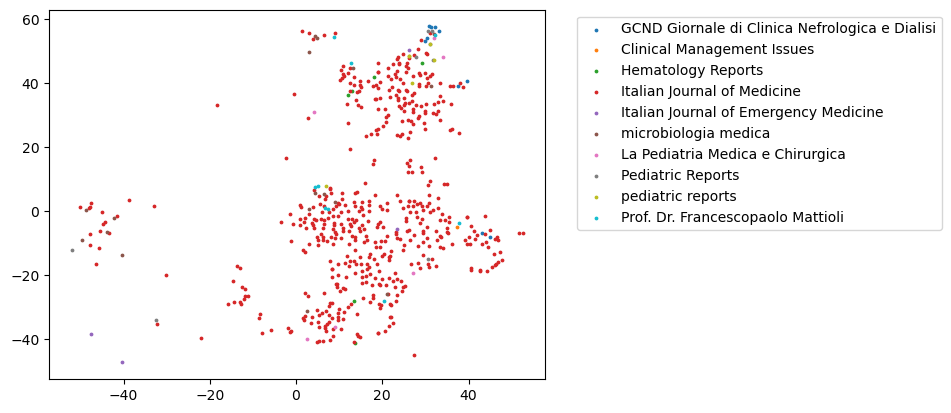

In [28]:
for source in dfOther['Source'].unique():
    plt.scatter(dfOther[dfOther['Source'] == source]['EmbeddingsTsneDim0'], 
                dfOther[dfOther['Source'] == source]['EmbeddingsTsneDim1'], 
                s=3, label=source)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

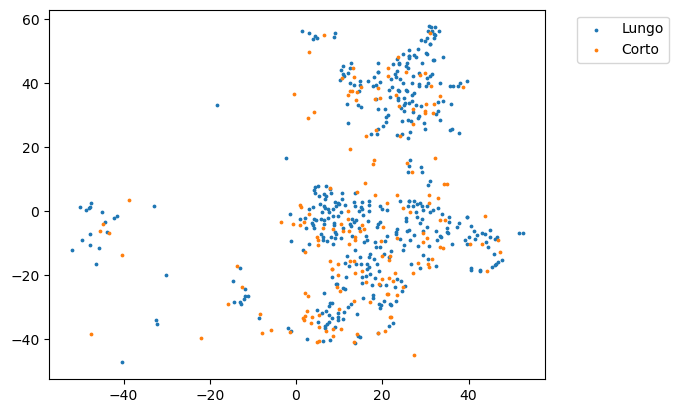

In [29]:
for lunghezza in dfOther['VecLunghezza'].unique():
    plt.scatter(dfOther[dfOther['VecLunghezza']==lunghezza]['EmbeddingsTsneDim0'],
                dfOther[dfOther['VecLunghezza']==lunghezza]['EmbeddingsTsneDim1'], s = 3, label = lunghezza)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()




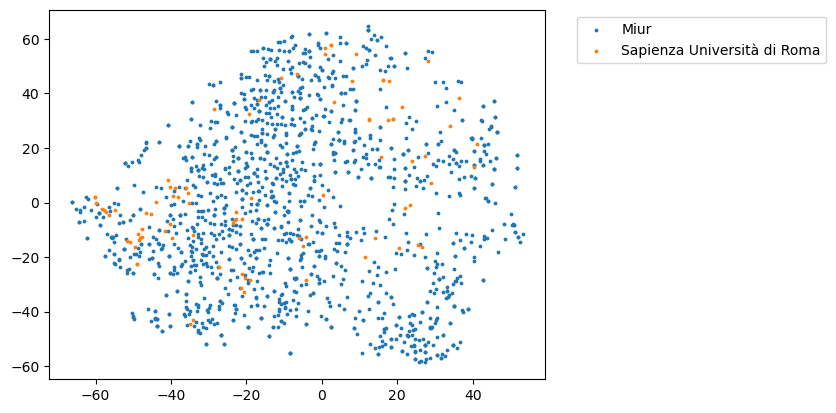

In [30]:
for source in dfMiurSap['Source'].unique():
    plt.scatter(dfMiurSap[dfMiurSap['Source'] == source]['EmbeddingsTsneDim0'], 
                dfMiurSap[dfMiurSap['Source'] == source]['EmbeddingsTsneDim1'], 
                s=3, label=source)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

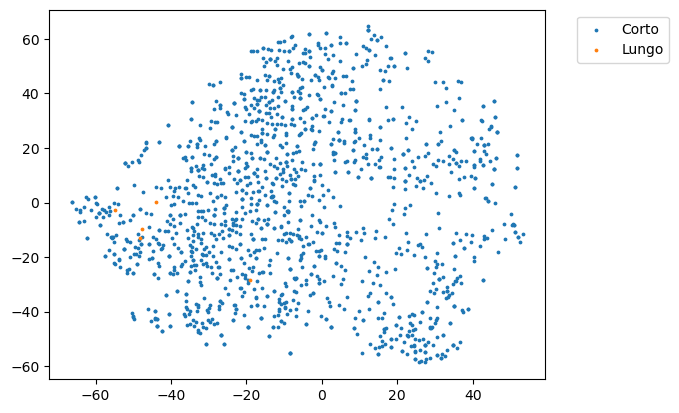

In [31]:
for lunghezza in dfMiurSap['VecLunghezza'].unique():
    plt.scatter(dfMiurSap[dfMiurSap['VecLunghezza']==lunghezza]['EmbeddingsTsneDim0'],
                dfMiurSap[dfMiurSap['VecLunghezza']==lunghezza]['EmbeddingsTsneDim1'], s = 3, label = lunghezza)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Creo numpy matrix che contengano solo gli embedding dei due gruppi Other e MiurSap

In [32]:
emb3Other = emb3[dfOther['Index']]
emb3MiurSap = emb3[dfMiurSap['Index']]


# Sul layer 3 vedo clustering di MiurSap

Clustering sugli embeddings con euclidean distance (non l'ideale per curse of dimensionality).
Non sono riuscito a modificare la metrica in "cosine", alternativamente posso diminuire la dimensionalità degli embeddings prodotti da infoGraph (chiedo al Vittorio).

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


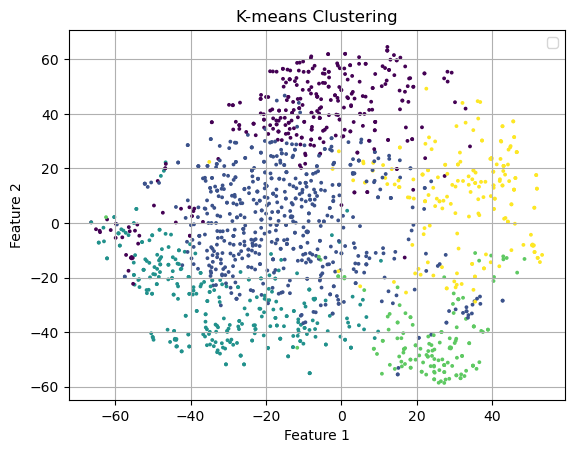

In [33]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(emb3MiurSap)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
plt.scatter(dfMiurSap['EmbeddingsTsneDim0'], dfMiurSap['EmbeddingsTsneDim1'], c=labels, cmap='viridis', s=3)
# Plot cluster centroids

plt.title('K-means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

CLustering con la matrice delle distanze (cosine similarity)

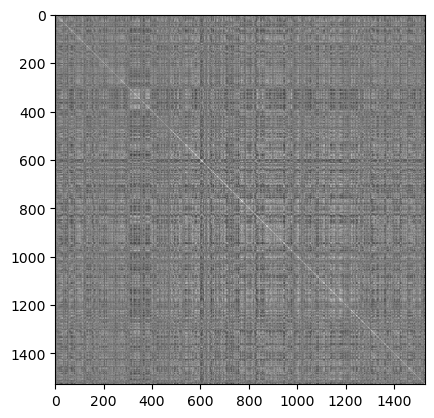

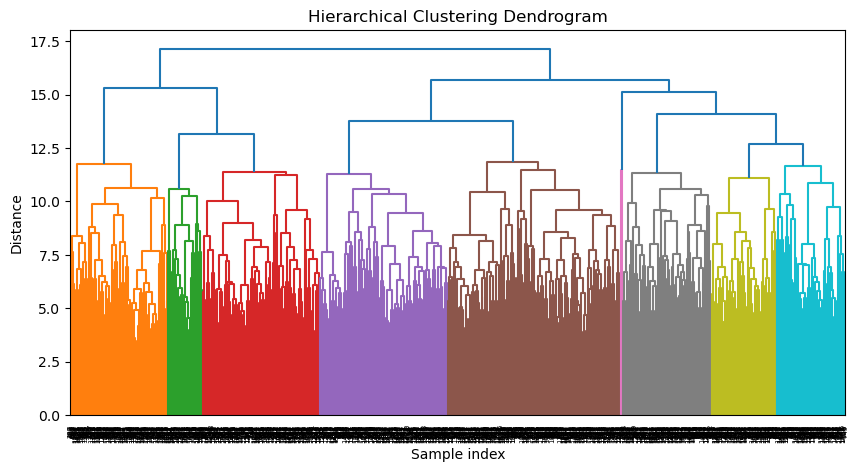

Numero di cluster: 5
Etichette dei cluster: [2 1 4 ... 4 4 4]


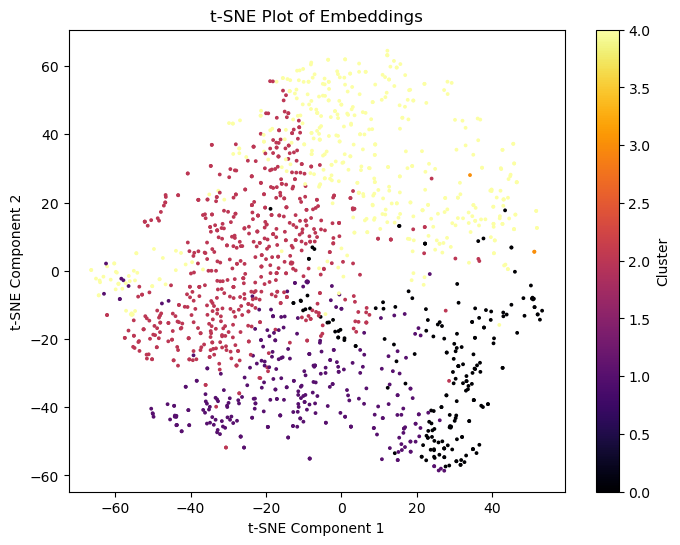

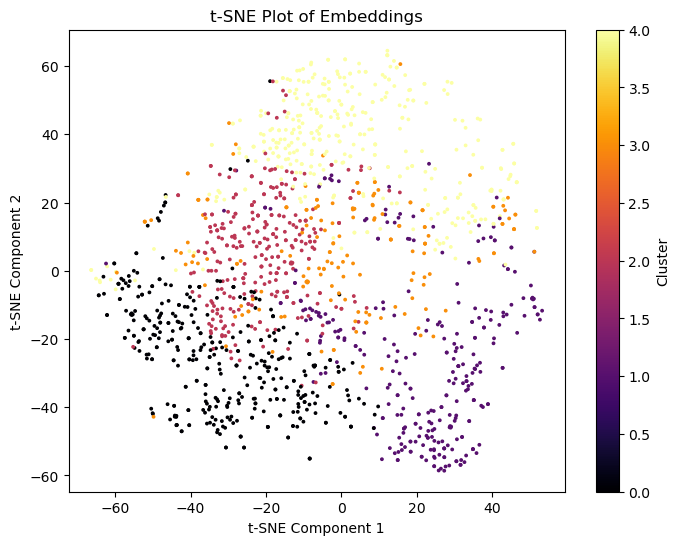

In [35]:
from sklearn.metrics.pairwise import cosine_similarity

# Calcola la matrice di similarità coseno
similarity_matrix = cosine_similarity(emb3MiurSap) # calcolo matrice di similarità documenti
import matplotlib.pyplot as plt

plt.imshow(similarity_matrix, cmap='gray')
plt.show()

from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

Z = linkage(similarity_matrix, method='average') # complete linkage mi sembra il migliore
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

from scipy.cluster.hierarchy import fcluster

# Determina i cluster tagliando il dendrogramma ad una certa altezza
max_d = 15  # Altezza di taglio del dendrogramma
clustersHierarchicaldoc2vec = fcluster(Z, max_d, criterion='distance')-1

# Stampa il numero di cluster e le etichette dei cluster
num_clusters = len(set(clustersHierarchicaldoc2vec))
print(f"Numero di cluster: {num_clusters}")
print("Etichette dei cluster:", clustersHierarchicaldoc2vec)


#KMEDOIDS

import numpy as np
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt

kmedoids = KMedoids(n_clusters=5, random_state=0)
kmedoids.fit(similarity_matrix)
clustersKMEDOIDSdoc2vec = kmedoids.labels_
centroids = similarity_matrix[kmedoids.medoid_indices_]

plt.figure(figsize=(8, 6))
plt.scatter(dfMiurSap['EmbeddingsTsneDim0'], dfMiurSap['EmbeddingsTsneDim1'], c=clustersHierarchicaldoc2vec, s =3, cmap='inferno')
plt.title('t-SNE Plot of Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(dfMiurSap['EmbeddingsTsneDim0'], dfMiurSap['EmbeddingsTsneDim1'], c=clustersKMEDOIDSdoc2vec, s=3,cmap ='inferno')
plt.title('t-SNE Plot of Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()


Domanda, dovrei rifare tsne solo su MiurSap e Other separati? io direi di no..

Vediamo ora qualè il parametro migliore di k, con la shiloutte score!

In [36]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

silhouette_score(similarity_matrix, clustersHierarchicaldoc2vec)

0.12134522

Osserviamo che hierarchical clustering non è affatto male visivamente! Ma ha una bassa silhoutte scre

Clusters fatti dalla matrice di similarità:

In [37]:
k_vec = [2,3,4,5,6,7,8,9]
silouette_scoresMedoidSimilarity = []
silouette_scoresMedoidEmbeddings=[]
silouette_scoresMeanSimilarity = []
silouette_scoresMeanEmbeddings = []


for k in k_vec:
    kmedoids = KMedoids(n_clusters=k, random_state=1)
    kmedoids.fit(similarity_matrix)
    clustersKMEDOIDSdoc2vec = kmedoids.labels_
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(similarity_matrix)
    clustersKMeans = kmeans.labels_
    #print(silhouette_score(emb3MiurSap, clustersKMEDOIDSdoc2vec),k,'kmedoids')
    silouette_scoresMedoidEmbeddings.append(silhouette_score(emb3MiurSap, clustersKMEDOIDSdoc2vec))
    #print(silhouette_score(similarity_matrix, clustersKMEDOIDSdoc2vec),k,'\n')
    silouette_scoresMedoidSimilarity.append(silhouette_score(similarity_matrix, clustersKMEDOIDSdoc2vec))

    #print(silhouette_score(emb3MiurSap, clustersKMeans),k,'clustersKMeans')
    silouette_scoresMeanEmbeddings.append(silhouette_score(emb3MiurSap, clustersKMeans))

    #print(silhouette_score(similarity_matrix, clustersKMeans),k,'\n')
    silouette_scoresMeanSimilarity.append(silhouette_score(similarity_matrix, clustersKMeans))

    

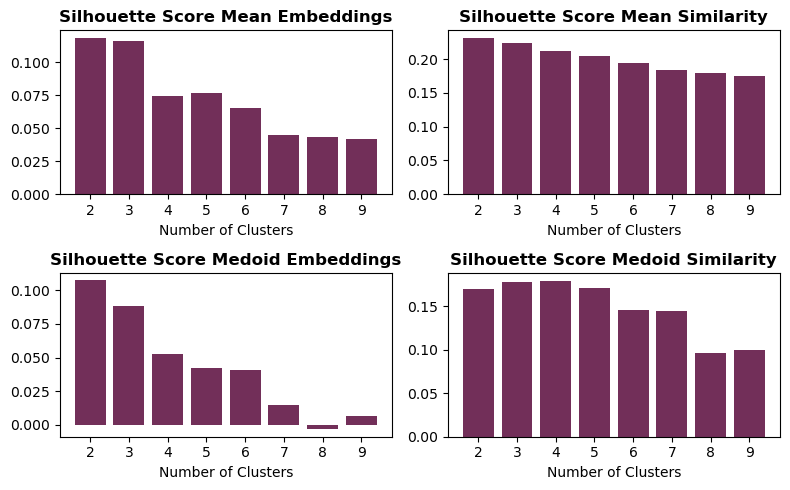

In [38]:
import matplotlib.pyplot as plt

# List of K values
k_vec = [2, 3, 4, 5, 6, 7, 8, 9]

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 5))

# Plot each silhouette score in a subplot
axs[0, 0].bar(k_vec, silouette_scoresMeanEmbeddings, align='center', color='#722f59')
axs[0, 0].set_title('Silhouette Score Mean Embeddings', fontweight='bold')
axs[0, 0].set_xlabel('Number of Clusters')
axs[0, 0].set_xticks(k_vec)
axs[0, 1].bar(k_vec, silouette_scoresMeanSimilarity, align='center', color='#722f59')
axs[0, 1].set_title('Silhouette Score Mean Similarity', fontweight='bold')
axs[0, 1].set_xlabel('Number of Clusters')
axs[0, 1].set_xticks(k_vec)
axs[1, 0].bar(k_vec, silouette_scoresMedoidEmbeddings, align='center', color='#722f59')
axs[1, 0].set_title('Silhouette Score Medoid Embeddings', fontweight='bold')
axs[1, 0].set_xlabel('Number of Clusters')
axs[1, 0].set_xticks(k_vec)
axs[1, 1].bar(k_vec, silouette_scoresMedoidSimilarity, align='center', color='#722f59')
axs[1, 1].set_title('Silhouette Score Medoid Similarity', fontweight='bold')
axs[1, 1].set_xlabel('Number of Clusters')
axs[1, 1].set_xticks(k_vec)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

Vediamo che le silhouette scores sono meglio con la similarity matrix. Scegliamo quindi k = 4 e valutiamo i risultati in entrambi i metodi

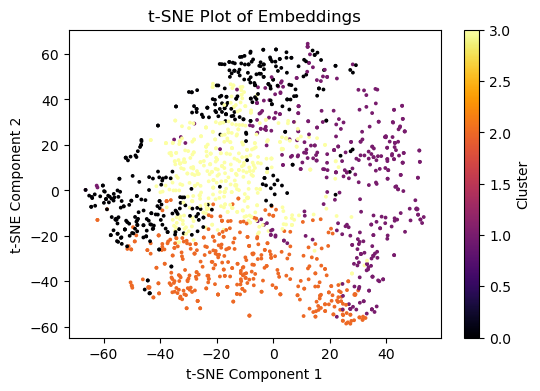

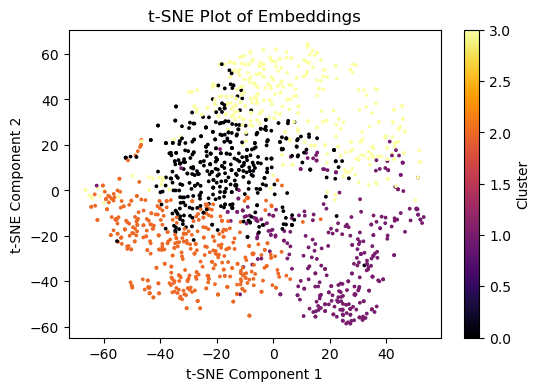

In [39]:
kmedoids = KMedoids(n_clusters=4, random_state=0)
kmedoids.fit(similarity_matrix)
clustersKMEDOIDSdoc2vec = kmedoids.labels_
centroids = similarity_matrix[kmedoids.medoid_indices_]

kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(similarity_matrix)
clustersKMeans = kmeans.labels_

plt.figure(figsize=(6, 4))
plt.scatter(dfMiurSap['EmbeddingsTsneDim0'], dfMiurSap['EmbeddingsTsneDim1'], c=clustersKMEDOIDSdoc2vec, s =3, cmap='inferno')
plt.title('t-SNE Plot of Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(dfMiurSap['EmbeddingsTsneDim0'], dfMiurSap['EmbeddingsTsneDim1'], c=clustersKMeans, s=3,cmap ='inferno')
plt.title('t-SNE Plot of Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

Clusters fatti con gli embeddings puri

In [40]:
k_vec = [2,3,4,5,6,7,8,9]
silouette_scoresMedoidSimilarity = []
silouette_scoresMedoidEmbeddings=[]
silouette_scoresMeanSimilarity = []
silouette_scoresMeanEmbeddings = []


for k in k_vec:
    kmedoids = KMedoids(n_clusters=k, random_state=1)
    kmedoids.fit(emb3MiurSap)
    clustersKMEDOIDSdoc2vec = kmedoids.labels_
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(emb3MiurSap)
    clustersKMeans = kmeans.labels_
    #print(silhouette_score(emb3MiurSap, clustersKMEDOIDSdoc2vec),k,'kmedoids')
    silouette_scoresMedoidEmbeddings.append(silhouette_score(emb3MiurSap, clustersKMEDOIDSdoc2vec))
    #print(silhouette_score(similarity_matrix, clustersKMEDOIDSdoc2vec),k,'\n')
    silouette_scoresMedoidSimilarity.append(silhouette_score(similarity_matrix, clustersKMEDOIDSdoc2vec))

    #print(silhouette_score(emb3MiurSap, clustersKMeans),k,'clustersKMeans')
    silouette_scoresMeanEmbeddings.append(silhouette_score(emb3MiurSap, clustersKMeans))

    #print(silhouette_score(similarity_matrix, clustersKMeans),k,'\n')
    silouette_scoresMeanSimilarity.append(silhouette_score(similarity_matrix, clustersKMeans))


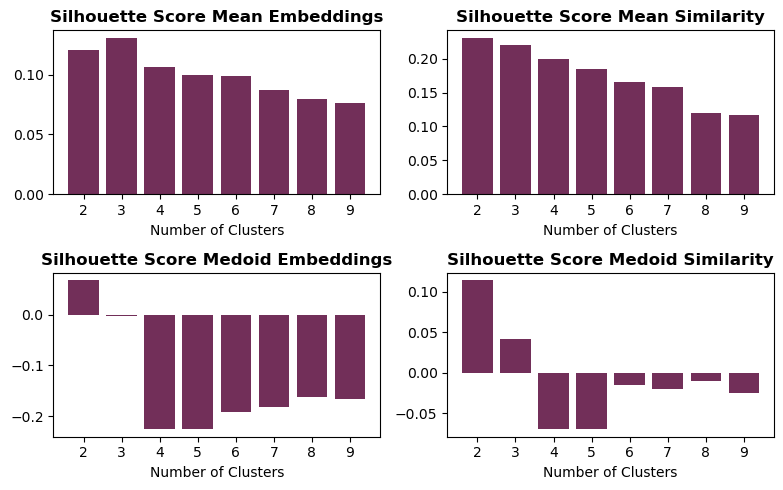

In [41]:
# List of K values
k_vec = [2, 3, 4, 5, 6, 7, 8, 9]

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 5))

# Plot each silhouette score in a subplot
axs[0, 0].bar(k_vec, silouette_scoresMeanEmbeddings, align='center', color='#722f59')
axs[0, 0].set_title('Silhouette Score Mean Embeddings', fontweight='bold')
axs[0, 0].set_xlabel('Number of Clusters')
axs[0, 0].set_xticks(k_vec)
axs[0, 1].bar(k_vec, silouette_scoresMeanSimilarity, align='center', color='#722f59')
axs[0, 1].set_title('Silhouette Score Mean Similarity', fontweight='bold')
axs[0, 1].set_xlabel('Number of Clusters')
axs[0, 1].set_xticks(k_vec)
axs[1, 0].bar(k_vec, silouette_scoresMedoidEmbeddings, align='center', color='#722f59')
axs[1, 0].set_title('Silhouette Score Medoid Embeddings', fontweight='bold')
axs[1, 0].set_xlabel('Number of Clusters')
axs[1, 0].set_xticks(k_vec)
axs[1, 1].bar(k_vec, silouette_scoresMedoidSimilarity, align='center', color='#722f59')
axs[1, 1].set_title('Silhouette Score Medoid Similarity', fontweight='bold')
axs[1, 1].set_xlabel('Number of Clusters')
axs[1, 1].set_xticks(k_vec)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

Osserviamo che kmedoid funziona molto male qui. Quindi scegliamo k = 2.

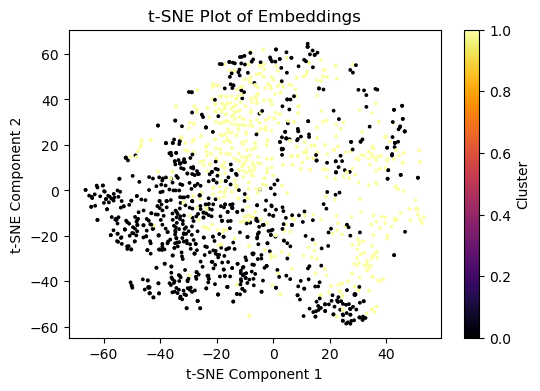

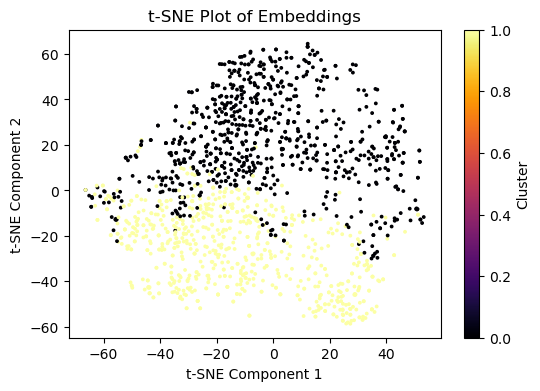

In [42]:
kmedoids = KMedoids(n_clusters=2, random_state=0)
kmedoids.fit(emb3MiurSap)
clustersKMEDOIDSdoc2vec = kmedoids.labels_
centroids = similarity_matrix[kmedoids.medoid_indices_]

kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(emb3MiurSap)
clustersKMeans = kmeans.labels_

plt.figure(figsize=(6, 4))
plt.scatter(dfMiurSap['EmbeddingsTsneDim0'], dfMiurSap['EmbeddingsTsneDim1'], c=clustersKMEDOIDSdoc2vec, s =3, cmap='inferno')
plt.title('t-SNE Plot of Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(dfMiurSap['EmbeddingsTsneDim0'], dfMiurSap['EmbeddingsTsneDim1'], c=clustersKMeans, s=3,cmap ='inferno')
plt.title('t-SNE Plot of Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

k-means lavora bene anche con gli embeddings quindi sembra che non stiamo avendo problemi di curse of dimensionality!

# Sul layer 3 vedo clustering di Other
ripeto paro paro quello che ho fatto per MiurSap

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


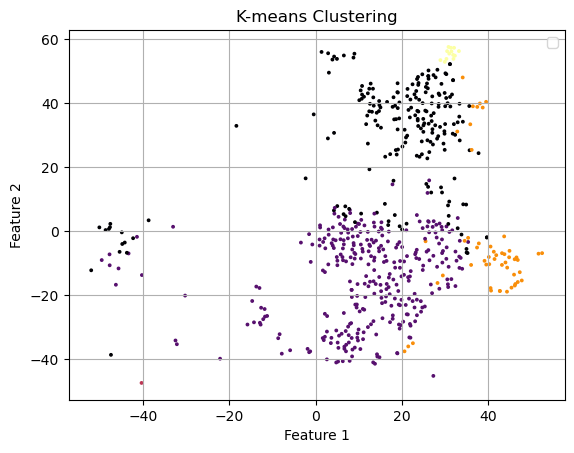

In [43]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(emb3Other)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

plt.scatter(dfOther['EmbeddingsTsneDim0'], dfOther['EmbeddingsTsneDim1'], c=labels, cmap='inferno', s=3)
# Plot cluster centroids

plt.title('K-means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

clustering con matrice di similarità

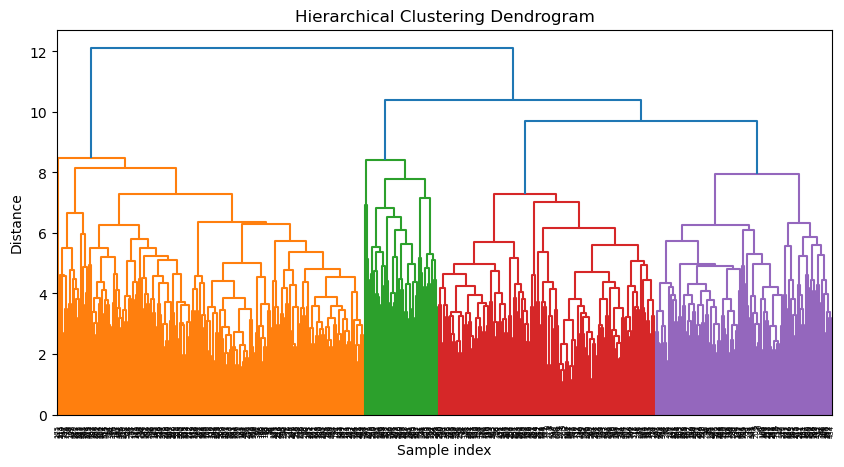

Numero di cluster: 4
Etichette dei cluster: [2 2 2 3 2 3 3 3 2 2 3 2 2 2 2 0 0 3 0 3 2 0 1 0 0 0 0 0 2 2 2 1 3 0 2 0 0
 2 0 0 2 3 0 0 0 0 1 3 1 3 2 3 2 0 3 2 2 3 0 2 0 0 0 3 1 3 2 3 0 2 0 0 3 3
 0 2 3 2 0 3 0 2 0 0 1 1 0 1 0 2 3 2 0 2 3 0 3 0 0 0 0 0 1 3 3 0 3 3 0 3 2
 2 2 3 0 2 2 0 3 2 2 2 0 0 0 3 0 2 2 0 2 3 0 2 2 0 3 0 0 2 3 0 3 2 0 0 3 0
 0 0 0 1 0 3 0 2 2 2 0 0 0 0 0 1 3 0 3 0 0 3 3 3 2 3 0 0 2 0 2 0 2 3 1 0 2
 2 0 0 2 0 3 3 0 0 0 0 3 1 0 3 0 0 3 2 2 3 0 0 0 3 2 3 2 0 0 3 0 0 0 0 1 0
 3 3 0 0 0 3 3 0 0 3 0 3 0 0 0 0 0 3 2 3 0 0 2 0 0 1 2 3 2 2 3 1 3 2 3 0 2
 1 1 0 3 2 3 3 2 1 0 0 0 2 3 2 2 3 0 1 0 2 3 2 2 2 0 0 1 2 2 1 3 0 3 0 0 3
 3 0 0 2 3 2 0 2 3 2 1 3 0 2 3 0 0 0 0 0 0 2 2 3 0 0 3 0 3 0 2 0 1 2 3 0 0
 2 2 3 0 2 0 0 2 1 1 3 3 2 2 2 1 0 0 1 0 2 0 2 2 2 0 0 0 2 0 2 0 0 0 0 3 0
 2 2 2 3 0 1 3 1 2 2 2 2 2 1 2 2 0 2 1 0 3 1 0 2 2 0 0 0 3 3 0 3 0 0 0 2 0
 2 2 1 2 0 3 3 2 0 3 2 3 0 0 2 3 1 2 0 3 1 1 0 0 3 3 0 3 0 3 2 1 0 3 0 3 3
 2 2 0 0 3 0 3 2 2 2 0 2 3 0 0 3 0 3 2 0 3 3 0 0 1 3 0 2

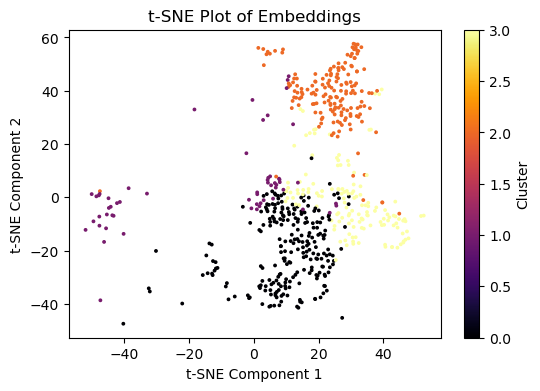

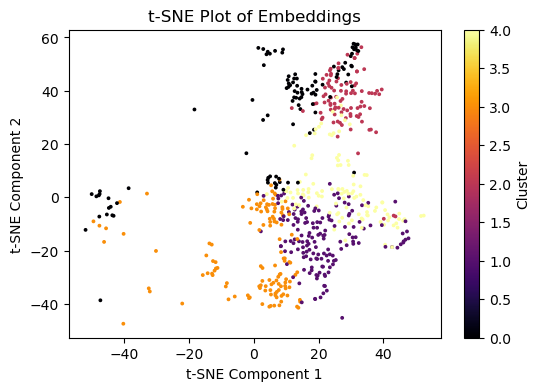

In [44]:
from sklearn.metrics.pairwise import cosine_similarity

# Calcola la matrice di similarità coseno
similarity_matrix = cosine_similarity(emb3Other) # calcolo matrice di similarità documenti
import matplotlib.pyplot as plt

#plt.imshow(similarity_matrix, cmap='gray')
#plt.show()

from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

Z = linkage(similarity_matrix, method='average') # complete linkage mi sembra il migliore
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

from scipy.cluster.hierarchy import fcluster

# Determina i cluster tagliando il dendrogramma ad una certa altezza
max_d = 9  # Altezza di taglio del dendrogramma
clustersHierarchicaldoc2vec = fcluster(Z, max_d, criterion='distance')-1

# Stampa il numero di cluster e le etichette dei cluster
num_clusters = len(set(clustersHierarchicaldoc2vec))
print(f"Numero di cluster: {num_clusters}")
print("Etichette dei cluster:", clustersHierarchicaldoc2vec)


#KMEDOIDS

import numpy as np
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt

kmedoids = KMedoids(n_clusters=5, random_state=0)
kmedoids.fit(similarity_matrix)
clustersKMEDOIDSdoc2vec = kmedoids.labels_
centroids = similarity_matrix[kmedoids.medoid_indices_]

plt.figure(figsize=(6, 4))
plt.scatter(dfOther['EmbeddingsTsneDim0'], dfOther['EmbeddingsTsneDim1'], c=clustersHierarchicaldoc2vec, s =3, cmap='inferno')
plt.title('t-SNE Plot of Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(dfOther['EmbeddingsTsneDim0'], dfOther['EmbeddingsTsneDim1'], c=clustersKMEDOIDSdoc2vec, s=3,cmap ='inferno')
plt.title('t-SNE Plot of Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [45]:
k_vec = [2,3,4,5,6,7,8,9]
silouette_scoresMedoidSimilarity = []
silouette_scoresMedoidEmbeddings=[]
silouette_scoresMeanSimilarity = []
silouette_scoresMeanEmbeddings = []


for k in k_vec:
    kmedoids = KMedoids(n_clusters=k, random_state=1)
    kmedoids.fit(similarity_matrix)
    clustersKMEDOIDSdoc2vec = kmedoids.labels_
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(similarity_matrix)
    clustersKMeans = kmeans.labels_
    #print(silhouette_score(emb3MiurSap, clustersKMEDOIDSdoc2vec),k,'kmedoids')
    silouette_scoresMedoidEmbeddings.append(silhouette_score(emb3Other, clustersKMEDOIDSdoc2vec))
    #print(silhouette_score(similarity_matrix, clustersKMEDOIDSdoc2vec),k,'\n')
    silouette_scoresMedoidSimilarity.append(silhouette_score(similarity_matrix, clustersKMEDOIDSdoc2vec))

    #print(silhouette_score(emb3MiurSap, clustersKMeans),k,'clustersKMeans')
    silouette_scoresMeanEmbeddings.append(silhouette_score(emb3Other, clustersKMeans))

    #print(silhouette_score(similarity_matrix, clustersKMeans),k,'\n')
    silouette_scoresMeanSimilarity.append(silhouette_score(similarity_matrix, clustersKMeans))

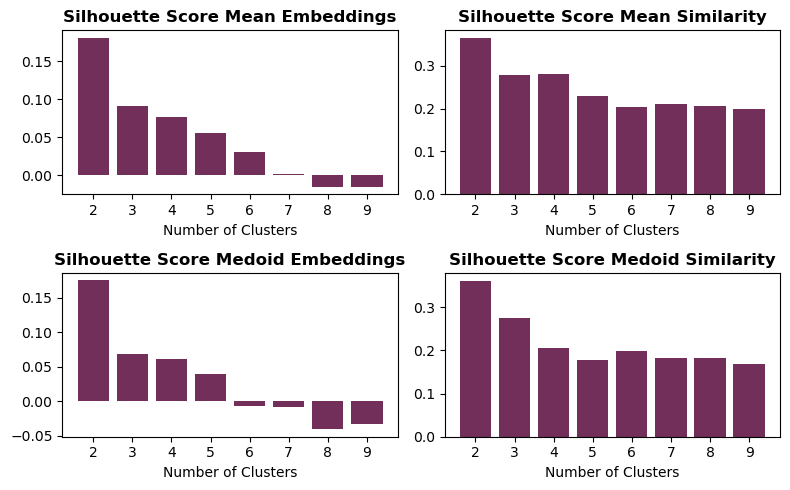

In [46]:
# List of K values
k_vec = [2, 3, 4, 5, 6, 7, 8, 9]

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 5))

# Plot each silhouette score in a subplot
axs[0, 0].bar(k_vec, silouette_scoresMeanEmbeddings, align='center', color='#722f59')
axs[0, 0].set_title('Silhouette Score Mean Embeddings', fontweight='bold')
axs[0, 0].set_xlabel('Number of Clusters')
axs[0, 0].set_xticks(k_vec)
axs[0, 1].bar(k_vec, silouette_scoresMeanSimilarity, align='center', color='#722f59')
axs[0, 1].set_title('Silhouette Score Mean Similarity', fontweight='bold')
axs[0, 1].set_xlabel('Number of Clusters')
axs[0, 1].set_xticks(k_vec)
axs[1, 0].bar(k_vec, silouette_scoresMedoidEmbeddings, align='center', color='#722f59')
axs[1, 0].set_title('Silhouette Score Medoid Embeddings', fontweight='bold')
axs[1, 0].set_xlabel('Number of Clusters')
axs[1, 0].set_xticks(k_vec)
axs[1, 1].bar(k_vec, silouette_scoresMedoidSimilarity, align='center', color='#722f59')
axs[1, 1].set_title('Silhouette Score Medoid Similarity', fontweight='bold')
axs[1, 1].set_xlabel('Number of Clusters')
axs[1, 1].set_xticks(k_vec)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

Osserviamo che la silhoutte score è molto alto in questo contesto "Other", con k = 2 nettamente vincitore

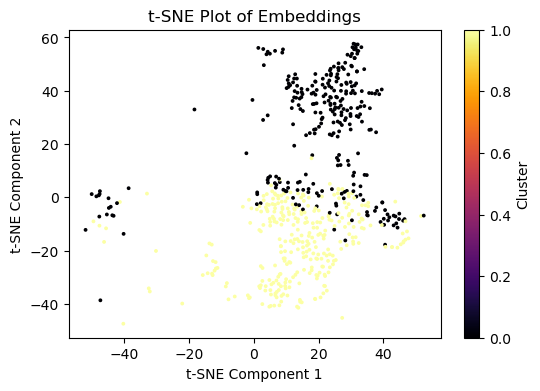

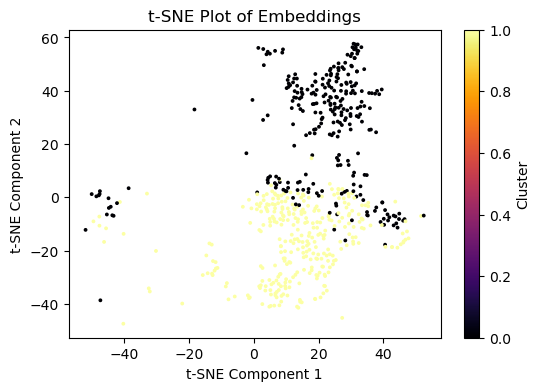

In [47]:
kmedoids = KMedoids(n_clusters=2, random_state=0)
kmedoids.fit(similarity_matrix)
clustersKMEDOIDSdoc2vec = kmedoids.labels_
centroids = similarity_matrix[kmedoids.medoid_indices_]

kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(similarity_matrix)
clustersKMeans = kmeans.labels_

plt.figure(figsize=(6, 4))
plt.scatter(dfOther['EmbeddingsTsneDim0'], dfOther['EmbeddingsTsneDim1'], c=clustersKMEDOIDSdoc2vec, s =3, cmap='inferno')
plt.title('t-SNE Plot of Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(dfOther['EmbeddingsTsneDim0'], dfOther['EmbeddingsTsneDim1'], c=clustersKMeans, s=3,cmap ='inferno')
plt.title('t-SNE Plot of Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

Vediamo che sia kmeans che kmedoids danno pressoche gli stessi risultati.

Vediamo ora il clustering fatto con gli embeddings puri:

In [48]:
k_vec = [2,3,4,5,6,7,8,9]
silouette_scoresMedoidSimilarity = []
silouette_scoresMedoidEmbeddings=[]
silouette_scoresMeanSimilarity = []
silouette_scoresMeanEmbeddings = []


for k in k_vec:
    kmedoids = KMedoids(n_clusters=k, random_state=1)
    kmedoids.fit(emb3Other)
    clustersKMEDOIDSdoc2vec = kmedoids.labels_
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(emb3Other)
    clustersKMeans = kmeans.labels_
    #print(silhouette_score(emb3MiurSap, clustersKMEDOIDSdoc2vec),k,'kmedoids')
    silouette_scoresMedoidEmbeddings.append(silhouette_score(emb3Other, clustersKMEDOIDSdoc2vec))
    #print(silhouette_score(similarity_matrix, clustersKMEDOIDSdoc2vec),k,'\n')
    silouette_scoresMedoidSimilarity.append(silhouette_score(similarity_matrix, clustersKMEDOIDSdoc2vec))

    #print(silhouette_score(emb3MiurSap, clustersKMeans),k,'clustersKMeans')
    silouette_scoresMeanEmbeddings.append(silhouette_score(emb3Other, clustersKMeans))

    #print(silhouette_score(similarity_matrix, clustersKMeans),k,'\n')
    silouette_scoresMeanSimilarity.append(silhouette_score(similarity_matrix, clustersKMeans))

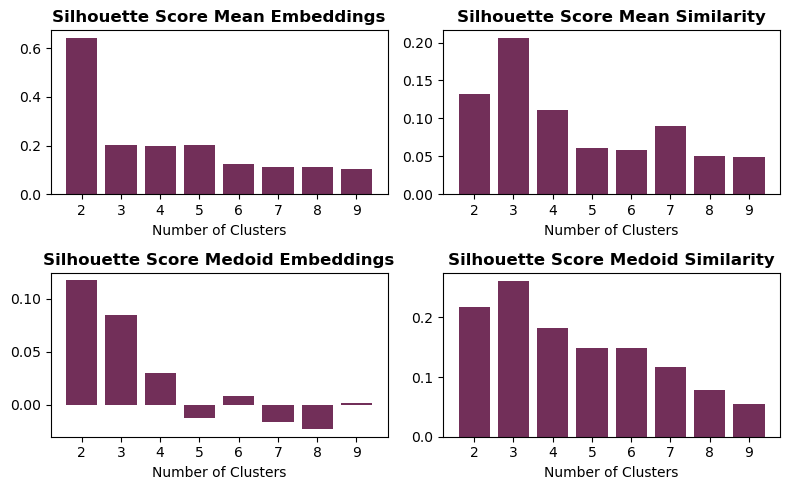

In [49]:
# List of K values
k_vec = [2, 3, 4, 5, 6, 7, 8, 9]

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 5))

# Plot each silhouette score in a subplot
axs[0, 0].bar(k_vec, silouette_scoresMeanEmbeddings, align='center', color='#722f59')
axs[0, 0].set_title('Silhouette Score Mean Embeddings', fontweight='bold')
axs[0, 0].set_xlabel('Number of Clusters')
axs[0, 0].set_xticks(k_vec)
axs[0, 1].bar(k_vec, silouette_scoresMeanSimilarity, align='center', color='#722f59')
axs[0, 1].set_title('Silhouette Score Mean Similarity', fontweight='bold')
axs[0, 1].set_xlabel('Number of Clusters')
axs[0, 1].set_xticks(k_vec)
axs[1, 0].bar(k_vec, silouette_scoresMedoidEmbeddings, align='center', color='#722f59')
axs[1, 0].set_title('Silhouette Score Medoid Embeddings', fontweight='bold')
axs[1, 0].set_xlabel('Number of Clusters')
axs[1, 0].set_xticks(k_vec)
axs[1, 1].bar(k_vec, silouette_scoresMedoidSimilarity, align='center', color='#722f59')
axs[1, 1].set_title('Silhouette Score Medoid Similarity', fontweight='bold')
axs[1, 1].set_xlabel('Number of Clusters')
axs[1, 1].set_xticks(k_vec)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

Notiamo che invece facendo clustering sugli embeddings viene k = 3 come miglior scelta di k! Vediamo graficamente:

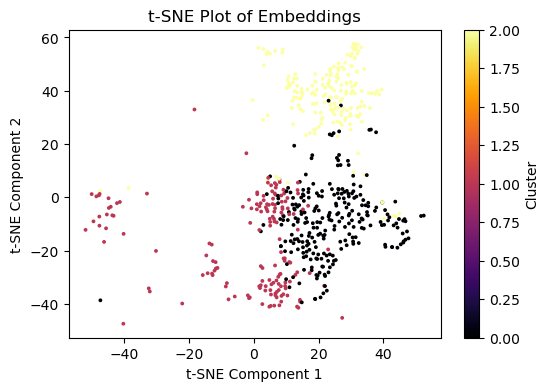

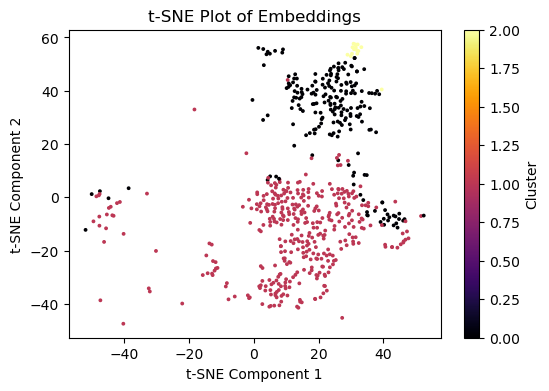

In [50]:
kmedoids = KMedoids(n_clusters=3, random_state=0)
kmedoids.fit(emb3Other)
clustersKMEDOIDSdoc2vec = kmedoids.labels_
centroids = similarity_matrix[kmedoids.medoid_indices_]

kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(emb3Other)
clustersKMeans = kmeans.labels_

plt.figure(figsize=(6, 4))
plt.scatter(dfOther['EmbeddingsTsneDim0'], dfOther['EmbeddingsTsneDim1'], c=clustersKMEDOIDSdoc2vec, s =3, cmap='inferno')
plt.title('t-SNE Plot of Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(dfOther['EmbeddingsTsneDim0'], dfOther['EmbeddingsTsneDim1'], c=clustersKMeans, s=3,cmap ='inferno')
plt.title('t-SNE Plot of Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Valutazione Labels fatte da chatgpt su layer 1

In [52]:
df_E3C = pd.read_excel('df_E3C.xlsx')

In [53]:
df_E3C

,Unnamed: 0,id,text,age,symptoms,gender,domain,diagnosis,outcome,Orthopedics,...,Rheumatology,Psychiatry,Internal Medicine,Geriatrics,Urology,Toxicology,Genetics,Pediatrics,Outcome_2,last_sentences
0,0,IT100002,"Anna è una donna di 47 anni, vive con il figli...",47.0,"['dolore retrosternale', 'sincope', 'dolore al...",F,"Orthopedics, Cardiology","Piede torto congenito, Dissezione acuta dell'a...",NaN,True,...,False,False,False,False,False,False,False,False,Improvement,"Infine, riesce a mettere in atto e a mantener..."
1,1,IT100003,"Gabriele è un uomo di 53 anni, affetto dal 200...",53.0,"['limitazione della funzione motoria', 'cadute...",M,"Neurology, Endocrinology","Distrofia muscolare di tipo 1, Diabete mellito...",NaN,False,...,False,False,False,False,False,False,False,False,Improvement,Ora si muove con la sua carrozzina elettrica ...
2,2,IT100010,È descritto il caso clinico di una donna di 84...,84.0,"['dolori osteoarticolari diffusi', 'febbricola...",F,"Pulmonology, Nephrology","Alveolite allergica estrinseca, Glomerulonefri...",NaN,False,...,False,False,False,False,False,False,False,False,Death,pneumoniae che determinava rapidamente il dec...
3,3,IT100015,Si descrive il caso di una paziente di anni 52...,52.0,['insufficienza renale avanzata'],F,Nephrology,Glomerulonefrite membranosa,NaN,False,...,False,False,False,False,False,False,False,False,Improvement,La misurazione del flusso dell’accesso esegui...
4,4,IT100027,"Un paziente di 83 anni nel dicembre 2006, rice...",83.0,"['disturbi urinari', 'metastasi ossee', 'progr...",M,Oncology,Carcinoma prostatico,NaN,False,...,False,False,False,False,False,False,False,False,Death,Il decesso del paziente avveniva dopo un anno...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,81,IT101493,Un ragazzo di 35 anni giunge all'osservazione ...,35.0,"['Bilateral lumbar pain', 'Increased intensity...",M,Nephrology,Renal enlargement with bilateral lumbar pain,Unknown,False,...,False,False,False,False,False,False,False,False,NaN,"Esame urine: microematuria, Peso specifico < ..."
82,82,IT101948,Una donna di 24 anni giunge all'attenzione med...,24.0,"['Febbricola da 6 mesi', 'Dolore in regione la...",F,Medicina interna,"Febbricola da 6 mesi, dolore in regione latero...",Unknown,False,...,False,False,True,False,False,False,False,False,NaN,La pressione arteriosa misurata al braccio de...
83,83,IT102056,Donna - aa. 30\n\nAnamnesi Patologica\nAsporta...,30.0,"['Dolore addominale', 'Vomito biliare', 'Febbre']",F,Ginecologia e Ostetricia,"Addome acuto con dolore addominale, vomito bil...",NaN,False,...,False,False,False,False,False,False,False,False,NaN,\n\nFollow-up e outcome senza particolarità de...
84,84,IT102057,Femmina - aa 37\n\nAnamnesi patologica remota\...,37.0,"['Episodi di dispepsia', 'Pirosi', 'Epigastral...",F,Gastroenterologia,Gastropatia ed esofagopatia da reflusso alcali...,NaN,False,...,False,False,False,False,False,False,False,False,Improvement,\nSono ripetuti gli esami funzionali che confe...


In [59]:
df_E3C.domain.unique()

array(['Orthopedics, Cardiology', 'Neurology, Endocrinology',
       'Pulmonology, Nephrology', 'Nephrology', 'Oncology',
       'Gastroenterology', 'Oncology/Hematology', 'Infectious Diseases',
       'Endocrinology', 'Rheumatology', 'Cardiology',
       'Cardiology, Oncology',
       'Gastroenterology, Cardiology, Vascular Surgery',
       'Neurology, Psychiatry', 'Infectious Diseases, Internal Medicine',
       'Orthopedics, Endocrinology, Geriatrics', 'Neurology',
       'Pulmonology', 'Cardiology and Vascular Surgery',
       'Medicina Interna', 'Cardiologia', 'Urologia', 'Gastroenterologia',
       'Infettivologia', 'Ematologia', 'Internal Medicine',
       'Emergency Medicine', 'Gastroenterology and Pulmonology',
       'Endocrinology and Gastroenterology', 'Toxicology',
       'Internal Medicine - Gastric Cancer',
       'Emergency Medicine - Acute Appendicitis',
       'Emergency Medicine - Bronchopneumonia',
       'Neurology - Anoxic Brain Injury',
       'Infectious Disease

In [ ]:
# sono troppe / avere la doppia/tripla categoria è difficile da gestire

C:\Users\enduser\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\enduser\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


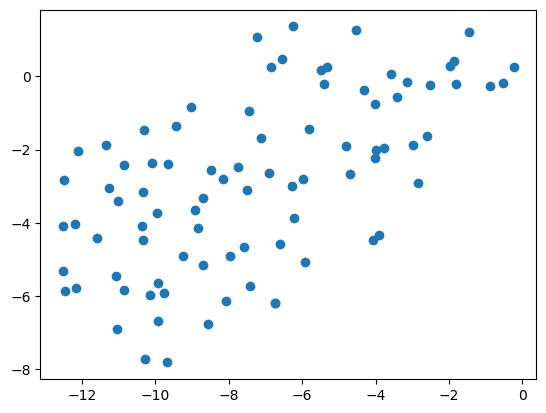

In [61]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(emb1)  # embeddings è la tua matrice di embedding
        
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1])

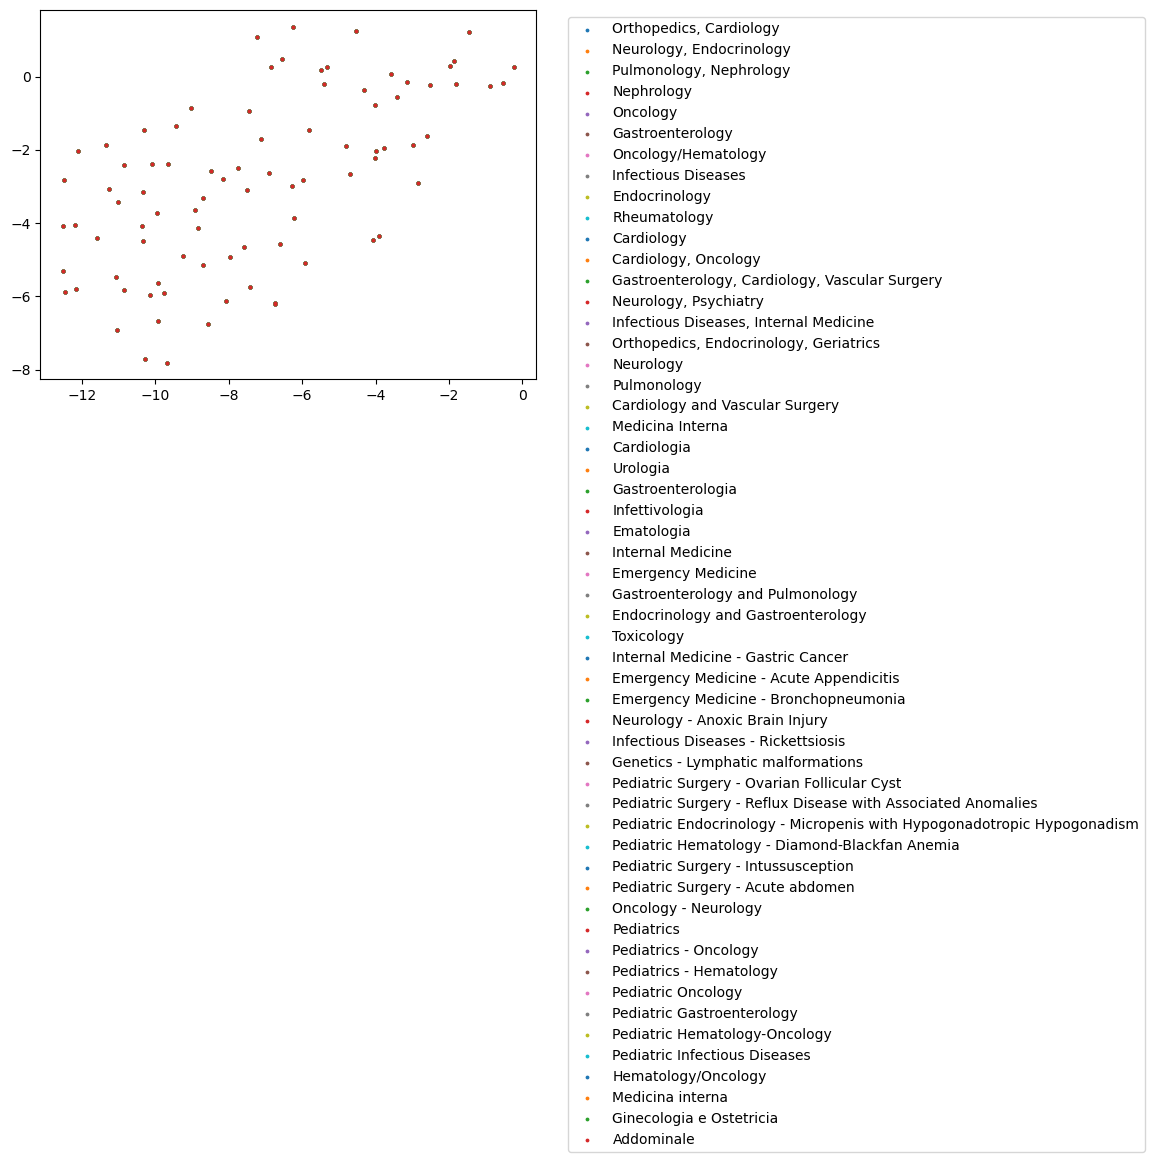

In [63]:
for domain in df_E3C['domain'].unique():
    plt.scatter(embeddings_tsne[:, 0],
                embeddings_tsne[:, 1], s = 3, label = domain)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()